In [1]:
KAGGLE = False

isTrain = True
isInference = False

if isTrain == False and isInference == True:
    newDir = False
else:
    newDir = True

In [2]:
WANDB_HTTP_TIMEOUT=300
WANDB_INIT_TIMEOUT =600
WANDB_DEBUG=True

In [3]:
print(newDir)

True


## Import

In [5]:
import os
import gc
import sys
import glob
import time
import shutil
import random
import warnings
warnings.simplefilter("ignore")


import wandb
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GroupKFold, StratifiedGroupKFold

from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from torch.cuda import amp
import torch
print(f"pytorch version is {torch.__version__}")
import torch.nn as nn
from torch.cuda import amp

import torchvision
from torchvision.transforms import v2 as transforms

import librosa
import torchaudio
import torchaudio.transforms as audioT

if KAGGLE == False:
    import nnAudio
    from nnAudio import features
    import albumentations
    from audiomentations import Compose, SpecCompose, OneOf, AddGaussianNoise, AddColorNoise
    from audiomentations import TimeStretch, PitchShift, Shift, SpecFrequencyMask, TimeMask
    from audiomentations import Gain, GainTransition
    from torcheval.metrics.functional import multiclass_auroc, multiclass_f1_score, multiclass_precision, multiclass_recall, multilabel_accuracy
if KAGGLE == False:
    from adan_pytorch import Adan
import timm

pytorch version is 2.3.0+cu121


INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.10 (you have 1.4.8). Upgrade using: pip install --upgrade albumentations


In [6]:
timm.list_models("*ec*")

['eca_botnext26ts_256',
 'eca_halonext26ts',
 'eca_nfnet_l0',
 'eca_nfnet_l1',
 'eca_nfnet_l2',
 'eca_nfnet_l3',
 'eca_resnet33ts',
 'eca_resnext26ts',
 'eca_vovnet39b',
 'ecaresnet26t',
 'ecaresnet50d',
 'ecaresnet50d_pruned',
 'ecaresnet50t',
 'ecaresnet101d',
 'ecaresnet101d_pruned',
 'ecaresnet200d',
 'ecaresnet269d',
 'ecaresnetlight',
 'ecaresnext26t_32x4d',
 'ecaresnext50t_32x4d',
 'nf_ecaresnet26',
 'nf_ecaresnet50',
 'nf_ecaresnet101',
 'selecsls42',
 'selecsls42b',
 'selecsls60',
 'selecsls60b',
 'selecsls84']

In [7]:
class config:
    if KAGGLE:
        dir = "/kaggle/input/birdclef-2024/"
    else:
        dir = "./"

    wave_path = "train_wave"

    # model_name = 'eca_nfnet_l0'
    model_name = 'tf_efficientnet_b0'

    pool_type = 'avg'

    wandb = True
    train_duration = 30 ##학습 시 데이터 DURATION
    slice_duration = 5 ##STFT 데이터 사이즈

    test_duration = 5

    train_drop_duration = 1
    
    ###spectrogram parameters
    sr = 32000
    fmin = 20
    fmax = 15000

    n_mels = 128
    n_fft = n_mels*8
    size_x = 512
    
    hop_length = int(sr*slice_duration / size_x)
    test_hop_length = int(sr*test_duration / size_x)
    
    bins_per_octave = 12

    nfolds = 5
    inference_folds = [4]
    
    enable_amp = True
    train_batchsize = 32
    valid_batchsize = 1

    # loss_type = "BCEWithLogitsLoss"
    loss_type = "BCEFocalLoss"

    lr = 1.0e-03 #for tf_efficientnet_b0
    # lr = 1.0e-04 #for movilenet
    # lr = 1.0e-05 #for movilenet

    optimizer='adan'
    # optimizer='adamW'
    weight_decay = 1.0e-02
    es_patience =  5
    deterministic = True
    enable_amp = True

    max_epoch = 9
    aug_epoch = 6
    

    useSecondary =True
    secondary_label_value = 0.5
    oversample =False
    oversample_threshold = 60
    
    seed = 42

    wandb = True

    ###augmentation flags
    aug_noise            = 0.
    aug_gain             = 0.0
    aug_wave_pitchshift  = 0.0 
    aug_wave_shift       = 0.

    aug_spec_xymasking   = 0.
    aug_spec_coarsedrop  = 0.
    aug_spec_hflip       = 0.

    ##mixup param
    aug_wave_mixup       = 1.0
    aug_spec_mixup       = 0.0
    aug_spec_mixup_prob  = 0.5 
    alpha=0.95

    smoothing_value      = 0.0
    # spec_mix_mask_percent = 20
    
cfg = config()

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')


# device = torch.device('cpu')

print(device)

cuda:0


In [8]:
name='starter'

In [9]:
if KAGGLE == False:
    if cfg.wandb == True:
        wandb.login(key="yourkey")

    if newDir == True:
        new_dir_path_recursive = f"{name}/checkpoint"
    
        os.makedirs(new_dir_path_recursive, exist_ok=True)
        shutil.rmtree(new_dir_path_recursive)
        os.makedirs(new_dir_path_recursive, exist_ok=True)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: beckpro. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/user/.netrc


## augmentation 

In [11]:
if isTrain== True:

    normal_augment = Compose([
        OneOf([
            Gain(min_gain_in_db=-15, max_gain_in_db=15, p=1.0),
            GainTransition(min_gain_in_db=-24.0, max_gain_in_db=6.0,
                           min_duration=0.2, max_duration=6.0,  p=1.0)
        ], p=cfg.aug_gain),
        
        OneOf([
            AddGaussianNoise(p=1),
            AddColorNoise(p=1, min_snr_db=5, max_snr_db=20, min_f_decay=-3.01, max_f_decay=-3.01)
        ],p=cfg.aug_noise),
        # OneOf([
        #     AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.002, p=1),
        #     AddColorNoise(p=1, max_f_decay=-3.01, min_snr_db=5, max_snr_db=20, n_fft=cfg.n_fft)
        # ],p=cfg.aug_noise),
    
        PitchShift(min_semitones=-1, max_semitones=1, p=cfg.aug_wave_pitchshift),
        Shift(p=cfg.aug_wave_shift)
    ])
    alb_transform = [
        ### num_masks_x=1, num_masks_y=1 will change
        albumentations.XYMasking(num_masks_x=2, num_masks_y=1, 
                                 mask_x_length=cfg.size_x//30, mask_y_length=cfg.n_mels//30,
                                 fill_value=0, mask_fill_value=0, p=cfg.aug_spec_xymasking),
        albumentations.CoarseDropout(fill_value=0, min_holes=20, max_holes=50, p=cfg.aug_spec_coarsedrop),
        albumentations.HorizontalFlip(p=cfg.aug_spec_hflip)    
    ]
    albumentations_augment = albumentations.Compose(alb_transform)

In [12]:

def mixup(data, targets, alpha, mode="same_wave"):
    
    if mode == "same_wave":
        data = torch.tensor(data)
        indices = torch.randperm(data.size(0))
        shuffled_data = data[indices]
        # shuffled_targets = targets[indices]
        #print(indices)
        lam = np.random.beta(alpha, alpha)
        #print(lam)
        new_data = data * lam + shuffled_data * (1 - lam)   # 람다 비율 * 데이터 원본 + shuffled 데이터 1-람다
        # new_targets = targets * lam + shuffled_targets * (1 - lam)
        return new_data.numpy()
        
    elif mode == "other_wave":
        indices = torch.randperm(data.size(0))
        shuffled_data = data[indices]
        shuffled_targets = targets[indices]
    
        lam = np.random.beta(alpha, alpha)
        new_data = data * lam + shuffled_data * (1 - lam)
        new_targets = targets * lam + shuffled_targets * (1 - lam)
        return new_data, new_targets
    

In [13]:
if isTrain== True:
    spec_xymasking = albumentations.XYMasking(num_masks_x=2, num_masks_y=1, 
                                              mask_x_length=cfg.size_x // 10, mask_y_length=cfg.n_mels // 10,
                                              fill_value=0, mask_fill_value=0, p=1)

def spec_mixup(data, targets):
    type = data.dtype

    indices = torch.randperm(data.size(0))
    # print(indices)
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]

    ##masking
    data = np.array(data)
    data_transposed = np.transpose(data, (2, 3, 1, 0)) # 0 1 2 3 -> 2 3 1 0 
    data_transposed = spec_xymasking(image=data_transposed)["image"]
    data_transposed = np.transpose(data_transposed, (3, 2, 0, 1))  # 0 1 2 3 -> 3 2 0 1

    ##masking 위치
    diff = data - data_transposed
    mask = (diff != 0).astype(int)

    ##mask 위치를 적용
    shuffled_data_masked = (shuffled_data * mask)

    ##mixup
    new_data = torch.tensor(data_transposed, dtype=type) + torch.tensor(shuffled_data_masked, dtype=type)

    #lam은 mask 양으로 결정
    # print(data.size(0))
    lam = mask.sum() / len(data) / (cfg.n_mels*cfg.size_x)
    # print(lam)
    new_targets = targets * (1-lam) + shuffled_targets *lam

    return new_data, new_targets

In [14]:
spec_layer = torchaudio.transforms.MelSpectrogram(
    sample_rate=cfg.sr, hop_length=cfg.hop_length, n_fft=cfg.n_fft,
    n_mels=cfg.n_mels,f_min=cfg.fmin,f_max=cfg.fmax,mel_scale='slaney',center=True, pad_mode='reflect'
    # normalized=True
).to(device)

valid_spec_layer = torchaudio.transforms.MelSpectrogram(
    sample_rate=cfg.sr, hop_length=cfg.test_hop_length, n_fft=cfg.n_fft,
    n_mels=cfg.n_mels,f_min=cfg.fmin,f_max=cfg.fmax,mel_scale='slaney',center=True, pad_mode='reflect'
    # normalized=True
).to(device)

test_spec_layer = torchaudio.transforms.MelSpectrogram(
    sample_rate=cfg.sr, hop_length=cfg.test_hop_length, n_fft=cfg.n_fft,
    n_mels=cfg.n_mels,f_min=cfg.fmin,f_max=cfg.fmax,mel_scale='slaney',center=True, pad_mode='reflect'
    # normalized=True
).cpu()

In [15]:
print(newDir)

True


---

# csv preprocessing

In [16]:
sample_submission = pd.read_csv(cfg.dir+"sample_submission.csv")
LABELS = list(sample_submission.set_index("row_id").columns)
LABELS[:5]

['asbfly', 'ashdro1', 'ashpri1', 'ashwoo2', 'asikoe2']

In [17]:
sample_submission

row_id    asbfly   ashdro1   ashpri1   ashwoo2   asikoe2  \
0   soundscape_1446779_5  0.005495  0.005495  0.005495  0.005495  0.005495   
1  soundscape_1446779_10  0.005495  0.005495  0.005495  0.005495  0.005495   
2  soundscape_1446779_15  0.005495  0.005495  0.005495  0.005495  0.005495   

    asiope1   aspfly1   aspswi1   barfly1  ...   whbwoo2   whcbar1   whiter2  \
0  0.005495  0.005495  0.005495  0.005495  ...  0.005495  0.005495  0.005495   
1  0.005495  0.005495  0.005495  0.005495  ...  0.005495  0.005495  0.005495   
2  0.005495  0.005495  0.005495  0.005495  ...  0.005495  0.005495  0.005495   

     whrmun   whtkin2    woosan   wynlau1   yebbab1   yebbul3   zitcis1  
0  0.005495  0.005495  0.005495  0.005495  0.005495  0.005495  0.005495  
1  0.005495  0.005495  0.005495  0.005495  0.005495  0.005495  0.005495  
2  0.005495  0.005495  0.005495  0.005495  0.005495  0.005495  0.005495  

[3 rows x 183 columns]

In [18]:

train_csv = pd.read_csv(cfg.dir+"train_metadata.csv")

<Axes: xlabel='len_new_target'>

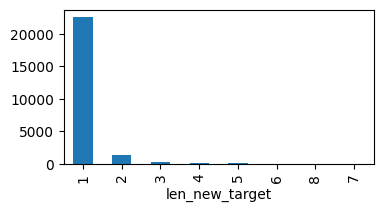

In [19]:
import ast
train_csv['new_target'] = train_csv['primary_label'] + ' ' + train_csv['secondary_labels'].map(lambda x: ' '.join(ast.literal_eval(x)))
train_csv['len_new_target'] = train_csv['new_target'].map(lambda x: len(x.split()))
train_csv["len_new_target"].value_counts().plot(kind="bar", figsize=(4,2))

In [20]:
train_csv["filename_tmp"] = train_csv["filename"].map(lambda x:x.split("/")[1][:-4])

In [21]:
duplicated_filenames = train_csv["filename_tmp"].value_counts()[train_csv["filename_tmp"].value_counts() > 1].index

In [22]:
duplicated_filenames

Index(['XC503389', 'XC306398', 'XC514027', 'XC447036', 'XC522123', 'XC403621',
       'XC574864', 'XC184466', 'XC659329', 'XC467373', 'XC209564', 'XC581045',
       'XC239509', 'XC209549', 'XC163901', 'XC674522', 'XC208795', 'XC208794',
       'XC209203'],
      dtype='object', name='filename_tmp')

In [23]:
train_csv = train_csv[~train_csv["filename_tmp"].isin(duplicated_filenames)]
train_csv = train_csv.reset_index(drop=True)

In [24]:
import numpy as np
import librosa
import soundfile as sf
from IPython.display import Audio

# Load the .npy file
wave = np.load('train_wave/asbfly/XC49755.npy')

sr = 32000 

# Display the audio
Audio(data=wave, rate=sr)

In [25]:
print(wave)

[ 8.77899595e-07 -3.59198339e-06  8.16617899e-07 ... -3.99618148e-04
  1.19200005e-04  3.47951063e-05]


# Dataset

wave = 1 차원 np array dtype = float

In [26]:
class BirdCLEF_Dataset(torch.utils.data.Dataset):
    def __init__(self, df, augmentation=False, mode='train'):
        if mode == 'train':
            self.df = df.reset_index(drop=True)
        elif mode == 'valid':
            self.df = df.reset_index(drop=True)
        else:
            self.df = df
        self.mode = mode
        self.augmentation = augmentation
    
    def __len__(self):
        return len(self.df)

    def normalize(self, x):
        valid_values = x[x != float('-inf')]
        mean_value = np.mean(valid_values)
        x[x == float('-inf')] = mean_value

        x = x - x.min()
        x = x / x.max()
        return x


    def wave_tile_and_cutoff(self, data):
        drop_duration = cfg.sr * cfg.train_drop_duration
        use_duration = cfg.sr * cfg.train_duration
        input_duration = cfg.sr * cfg.slice_duration

        if len(data) > drop_duration:  # Discard the first 1 second
            data = data[drop_duration:]

        # Tile if the length is less than use_duration
        if len(data) < use_duration:
            iter = (use_duration + len(data) - 1) // len(data)  # Ceiling division to ensure enough length
            data = np.tile(data, iter)

        # Ensure data length is a multiple of input_duration
        remainder = len(data) % input_duration
        if remainder != 0:
            padding_needed = input_duration - remainder
            data = np.pad(data, (0, padding_needed), 'constant')

        # Only use up to use_duration to prevent excessive memory usage
        data = data[:use_duration]

        # Verify the size before reshaping
        if len(data) % input_duration != 0:
            raise ValueError(f"Data length {len(data)} is not divisible by input_duration {input_duration}")

        return data


    def label_smoothing(self, idx, target):
    
        secondary_target = target * cfg.secondary_label_value
    
        out_of_target_noise_intensity = cfg.smoothing_value/(len(LABELS)-1) 
        out_of_target_noise_array = torch.ones(target.shape) * out_of_target_noise_intensity
        
        secondary_target_with_noise = secondary_target + out_of_target_noise_array
        secondary_target_with_noise = torch.clip(secondary_target_with_noise, min=0, max=cfg.secondary_label_value)
    
        primary_target = np.isin(LABELS, self.df.loc[idx, "primary_label"]).astype(int)
        primary_target = torch.tensor(primary_target, dtype=torch.float32)

        primary_and_secondary_target_with_noise = primary_target + secondary_target_with_noise
        new_target = torch.clip(primary_and_secondary_target_with_noise, min=0, max=1)
    
        new_target = new_target - primary_target * cfg.smoothing_value
    
        return new_target

    
    def __getitem__(self, idx):

        if self.mode == 'train':

            ### ------------------READ DATA  ------------------------------------
            if cfg.useSecondary == True:
                target = np.isin(LABELS, self.df.loc[idx, "new_target"].split()).astype(int)
            else:
                target = np.isin(LABELS, self.df.loc[idx, "primary_label"].split()).astype(int)
            target = torch.tensor(target, dtype=torch.float32)
            ### ------------------label smoothing  --------------------------
            target = self.label_smoothing(idx, target)
            
            fileID, _ = os.path.splitext(self.df.loc[idx, 'filename'])
            folder, filename = fileID.split('/')
            
            path = f"{cfg.wave_path}/{folder}/{filename}.npy"
            wave = np.load(path)

            ### -----------------------------------------------------------------

            # ---PREPROCESS wave length to train duration & slice duration-------
            wave = self.wave_tile_and_cutoff(data=wave)
            input_duration = cfg.sr * cfg.slice_duration
            # middle_shift = cfg.sr * cfg.train_duration // 2 
            
            # augmentation
            if self.augmentation == True:
                ### ------------------wave time mixup  --------------------------
                if cfg.aug_wave_mixup > np.random.random(): # mixup in same wave
                    #train_duration -> slice_duration
                    wave_reshape = wave.reshape(-1, input_duration)
                    wave = mixup(data=wave_reshape, targets=target, alpha=cfg.alpha, mode="same_wave")
                    wave = wave[:1,:]
                else:
                    wave = wave[:input_duration]
                
                ### ------------------wave augmentation  ------------------------
                wave = normal_augment(samples=wave, sample_rate=cfg.sr)

                ### ------------------MAKE SPECTROGRAM  -------------------------
                wave = torch.tensor(wave).to(device)
                mel_spec = spec_layer(wave)  # mel spec transform
                mel_spec = np.array(mel_spec.cpu())

                mel_spec = np.log(mel_spec)  # log spec
                for i in range(len(mel_spec)): 
                    mel_spec[i] = self.normalize(mel_spec[i]) # normalization
                mel_spec = torch.tensor(mel_spec)
                #print(f"train aug - mel_spec shape before slicing: {mel_spec.shape}") ( 1, 128, 513)

                
                try:
                    mel_spec = mel_spec[:, :, :cfg.size_x]
                except IndexError as e:
                    print(f"IndexError: {e}")
                    print(f"mel_spec shape during slicing: {mel_spec.shape}")
                    raise

                # (batch_size, n_mels, time)
                ### ------------------spec augmentation  ------------------------
                mel_spec = np.array(mel_spec.cpu())
                mel_spec = np.transpose(mel_spec, (1, 2, 0))        # (n_mels, time, batch_size)        
                mel_spec = albumentations_augment(image=mel_spec)["image"]
                mel_spec = np.transpose(mel_spec, (2, 0, 1))        # (batch_size, n_mels, time)

            # no augmentation 
            else:
                wave = wave[:input_duration]
                
                ### ------------------MAKE SPECTROGRAM  -------------------------
                wave = torch.tensor(wave).to(device)
                mel_spec = spec_layer(wave)
                mel_spec = np.array(mel_spec.cpu())

                mel_spec = np.log(mel_spec)

                for i in range(len(mel_spec)):
                    mel_spec[i] = self.normalize(mel_spec[i])
                    

                mel_spec = torch.tensor(mel_spec)
                if mel_spec.ndim == 2:
                    mel_spec = mel_spec.unsqueeze(0)  # Add batch dimension
                #print(f"train no aug - mel_spec shape before slicing: {mel_spec.shape}") (128, 513)
                try:
                    mel_spec = mel_spec[:, :, :cfg.size_x]
                except IndexError as e:
                    print(f"IndexError: {e}")
                    print(f"mel_spec shape during slicing: {mel_spec.shape}")
                    raise

            
            mel_spec = torch.tensor(mel_spec)

            
            return mel_spec, target

        elif self.mode == 'valid':
            
            ### ------------------READ DATA  ------------------------------------
            if cfg.useSecondary == True:
                target = np.isin(LABELS, self.df.loc[idx, "new_target"].split()).astype(int)
            else:
                target = np.isin(LABELS, self.df.loc[idx, "primary_target"].split()).astype(int)
            target = torch.tensor(target, dtype=torch.float32)
            
            fileID, _ = os.path.splitext(self.df.loc[idx, 'filename'])
            folder, filename = fileID.split('/')
            
            path = f"{cfg.wave_path}/{folder}/{filename}.npy"
            wave = np.load(path)
            ### -----------------------------------------------------------------

            # ---PREPROCESS wave length to train duration & slice duration-------
            wave = self.wave_tile_and_cutoff(data=wave)

            input_duration = cfg.sr*cfg.test_duration
            wave_reshape = wave.reshape(-1, input_duration)

            wave_reshape = torch.tensor(wave_reshape).to(device)
            mel_specs = valid_spec_layer(wave_reshape)
            mel_specs = mel_specs.cpu().numpy()

            mel_specs = np.log(mel_specs)
            for i in range(len(mel_specs)):
                mel_specs[i] = self.normalize(mel_specs[i])
            mel_specs = torch.tensor(mel_specs)
            #print(f"val - mel_spec shape before slicing: {mel_specs.shape}")  ( 6, 128, 513)
            #print(f"val - cfg.size_x: {cfg.size_x}")

            try:
                mel_specs = mel_specs[:, :, :cfg.size_x]
            except IndexError as e:
                print(f"IndexError: {e}")
                print(f"mel_spec shape during slicing: {mel_specs.shape}")
                raise

            targets = torch.tile(target, dims=(mel_specs.shape[0],1))
            return mel_specs, targets

        ###---------------------------------------------------------------------------------------------------------------------
        elif self.mode == 'test':

            filepath = self.df[idx]
            wave, _  = torchaudio.load(filepath)
            wave = wave[:60*4*32000]

            wave_reshaped = wave.reshape(-1, 1, cfg.test_duration*cfg.sr)

            mel_spec = test_spec_layer(wave_reshaped)
            mel_spec = np.log(mel_spec)

            mel_spec = np.array(mel_spec)
            for i in range(len(mel_spec)):
                mel_spec[i] = self.normalize(mel_spec[i])
            mel_spec = torch.tensor(mel_spec)

            mel_spec = mel_spec[:,:,:cfg.size_x]
            return mel_spec

        elif self.mode == 'clean':

            filepath = self.df[idx]
            wave, _  = torchaudio.load(filepath)

            wave = wave[:6*cfg.test_duration*cfg.sr]

            chunk_length = len(wave[0]) // (cfg.test_duration*cfg.sr)
            
            wave = wave[:chunk_length*cfg.test_duration*cfg.sr]

            wave_reshaped = wave.reshape(-1, 1, cfg.test_duration*cfg.sr)
            
            mel_spec = test_spec_layer(wave_reshaped)
            mel_spec = np.log(mel_spec)

            mel_spec = np.array(mel_spec)
            for i in range(len(mel_spec)):
                mel_spec[i] = self.normalize(mel_spec[i])
            mel_spec = torch.tensor(mel_spec)

            return mel_spec, filepath

train data


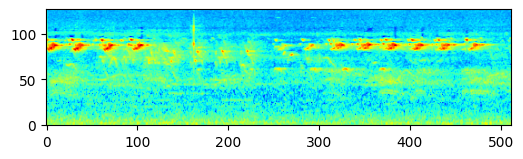

validation data


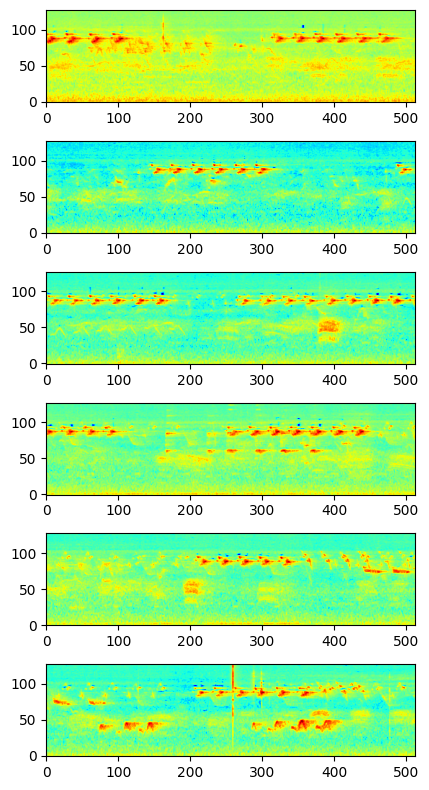

In [27]:
if isTrain:
    print("train data")
    dataset = BirdCLEF_Dataset(df=train_csv, augmentation=True,  mode="train")
    data, target = dataset[270]
    fig, ax = plt.subplots(figsize=(6,4))
    plt.imshow(data[0], cmap="jet", origin="lower")
    plt.show()
    
    print("validation data")
    dataset = BirdCLEF_Dataset(df=train_csv, augmentation=True,  mode="valid")
    data, target = dataset[270]
    fig, axes = plt.subplots(figsize=(12,8), nrows=len(data), tight_layout=True)
    for idx, ax in enumerate(axes.ravel()):
        ax.imshow(data[idx], cmap="jet", origin="lower")

# Model

## poolings

In [29]:
# class GeM(torch.nn.Module):
#     def __init__(self, p=3, eps=1e-6):
#         super(GeM, self).__init__()
#         self.p = torch.nn.Parameter(torch.ones(1) * p)
#         self.eps = eps

#     def forward(self, x):
#         bs, ch, h, w = x.shape
#         x = torch.nn.functional.avg_pool2d(x.clamp(min=self.eps).pow(self.p), (x.size(-2), x.size(-1))).pow(1.0 / self.p)
#         x = x.view(bs, ch)
#         return x

### simple efficientnet SEDmodel

In [30]:
class BirdModel(torch.nn.Module):
    def __init__(self, model_name, pretrained, in_channels, num_classes, pool="default"):
        super().__init__()

        self.pool = pool
        self.normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
        if pool == "default":
            self.backbone = timm.create_model(
                model_name=model_name, pretrained=pretrained,
                num_classes=0, in_chans=3)
        else:
            self.backbone = timm.create_model(
                model_name=model_name, pretrained=pretrained,
                num_classes=0, in_chans=3, global_pool="")

        in_features = self.backbone.num_features


        # self.pooling = torch.nn.MaxPool2d()
        # self.pooling = torch.nn.AvgPool2d()
        self.max_pooling = torch.nn.Sequential(torch.nn.AdaptiveMaxPool2d(1),
                                               torch.nn.Flatten(start_dim=1, end_dim=-1))
        self.avg_pooling = torch.nn.Sequential(torch.nn.AdaptiveAvgPool2d(1),
                                               torch.nn.Flatten(start_dim=1, end_dim=-1))
        self.both_pooling_neck = torch.nn.Sequential(torch.nn.BatchNorm1d(2*in_features),
                                                     torch.nn.Linear(in_features=2*in_features, out_features=in_features))
        
        self.head = torch.nn.Sequential(
            torch.nn.BatchNorm1d(in_features),
            torch.nn.Linear(in_features=in_features, out_features=256),
            torch.nn.Hardswish(inplace=True),torch.nn.Dropout(0.1),
            torch.nn.Linear(in_features=256, out_features=len(LABELS))  
        )



        self.active = torch.nn.Sigmoid()
    def forward(self, x):
        x = x.expand(-1, 3, -1, -1)
        x = self.normalize(x)
        x = self.backbone(x)

        if self.pool == "max":
            x = self.max_pooling(x)
        elif self.pool == "avg":
            x = self.avg_pooling(x)
        elif self.pool == "both":
            x_max = self.max_pooling(x)
            x_avg = self.avg_pooling(x)
            x = x_max + x_avg
            # x = torch.cat([x_max, x_avg], dim=1)
            # x = self.both_pooling_neck(x)
            
        x = self.head(x)
        # x = self.active(x)
        return x

# 5 Fold

In [33]:
# if isTrain:
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
skf = StratifiedKFold(n_splits=cfg.nfolds, shuffle=True, random_state=cfg.seed)
for fold, (train_index, valid_index) in enumerate(skf.split(train_csv, train_csv['primary_label'])):
    train_csv.loc[valid_index, 'fold'] = int(fold)

In [34]:
if isTrain:
    train_csv.groupby("fold", as_index=False)["primary_label"].value_counts()

## Seed Reproducibility

In [35]:
def set_random_seed(seed: int = 42, deterministic: bool = False):
    """Set seeds"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed) 
    torch.backends.cudnn.deterministic = deterministic  

### Loss

In [36]:
class BCEFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, preds, targets):
        bce_loss = nn.BCEWithLogitsLoss(reduction='none')(preds, targets)
        probas = torch.sigmoid(preds)

        tmp = targets * self.alpha * (1. - probas)**self.gamma * bce_loss
        smp = (1. - targets) * probas**self.gamma * bce_loss
        
        loss = tmp + smp
        loss = loss.mean()
        return loss

## Initialization

In [37]:
def initialization():
    model = BirdModel(model_name=cfg.model_name, pretrained=True, in_channels=3, num_classes=len(LABELS), pool=cfg.pool_type)
    
    if cfg.optimizer=='adan':
        optimizer = Adan(model.parameters(), lr=cfg.lr, betas=(0.02, 0.08, 0.01), weight_decay=cfg.weight_decay)
    else:
        optimizer = torch.optim.AdamW(params=model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer, epochs=cfg.max_epoch,
        pct_start=0.0, steps_per_epoch=len(train_dataloader),
        max_lr=cfg.lr, div_factor=25, final_div_factor=4.0e-01
    )
    
    scaler = amp.GradScaler(enabled=cfg.enable_amp)
    if cfg.loss_type == "BCEWithLogitsLoss":
        loss_func = torch.nn.BCEWithLogitsLoss()
    elif cfg.loss_type == "BCEFocalLoss":
        loss_func = BCEFocalLoss(alpha=1)
    
    return model.to(device), optimizer, scheduler, scaler, loss_func.to(device)

In [38]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error, roc_auc_score

## Trainer Function

In [39]:
def train_one_loop(model, optimizer, scaler, scheduler, dataloader, loss_fn):
    trainloss = 0; model.train()

    count = 0
    for idx, (data, label) in enumerate(tqdm(dataloader,leave=False ,desc="[train]")):
        
        data, label = data.to(device), label.to(device)
        
        optimizer.zero_grad()
        with amp.autocast(cfg.enable_amp, dtype=torch.bfloat16):
            pred = model.forward(data)
            loss = loss_fn(pred, label)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        scheduler.step()
        
        trainloss += loss.item()
        del data, label, loss
        count += 1

    trainloss /= len(dataloader)
    if cfg.wandb == True:
        wandb.log({f"train_loss": trainloss, f"lr":scheduler.get_lr()[0]})
    return model, optimizer, scaler, scheduler, trainloss


def mixup_one_loop(model, optimizer, scaler, scheduler, dataloader, loss_fn):
    trainloss = 0; model.train()

    count = 0
    for idx, (data, label) in enumerate(tqdm(dataloader,leave=False ,desc="[train]")):
        if np.random.random()>cfg.aug_spec_mixup_prob:
            data, label = mixup(data=data, targets=label, alpha=cfg.alpha, mode="other_wave")
        else:
            data, label = spec_mixup(data=data, targets=label)
        data, label = data.to(device), label.to(device)
        
        optimizer.zero_grad()
        with amp.autocast(cfg.enable_amp, dtype=torch.bfloat16):
        # with amp.autocast(cfg.enable_amp):
            pred = model.forward(data)
            loss = loss_fn(pred, label)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        scheduler.step()
        
        trainloss += loss.item()
        del data, label, loss
        count += 1

    trainloss /= len(dataloader)
    if cfg.wandb == True:
        wandb.log({f"train_loss": trainloss, f"lr":scheduler.get_lr()[0]})
    return model, optimizer, scaler, scheduler, trainloss


def evaluate_validation(model, dataloader, loss_fn):
    validloss=0
    model.eval()

    preds, trues, targets = [], [], []
    
    for idx, (data, label) in enumerate(tqdm(dataloader,leave=False ,desc="[valid]")):
        d = data[0].unsqueeze(1)
        label = label[0]
        
        d = d.to(device)
        pred = model.forward(d)

        preds.extend(pred.detach().cpu())
        trues.extend(label)
        targets.extend(label.argmax(axis=1))
        
    #======================== metrics ========================#
    y_preds = torch.stack(preds)
    t = torch.sigmoid(y_preds)
    targets = torch.tensor(targets)
    y_trues = torch.stack(trues)


    validloss = loss_fn(torch.stack(preds), torch.stack(trues))

    sk_f1_30 = metrics.f1_score(np.array(y_trues), np.array(t) > 0.30, average="micro")
    sk_f1_50 = metrics.f1_score(np.array(y_trues), np.array(t) > 0.50, average="micro")
    
    auc = multiclass_auroc(input=t, target=targets, num_classes=len(LABELS),
                           average="macro").item()
    
    prec = multiclass_precision(input=t, target=targets, num_classes=len(LABELS),
                           average="macro").item()

    f1 = multiclass_f1_score(input=t, target=torch.tensor(targets), num_classes=len(LABELS),
                             average="micro").item()

    f1_macro = multiclass_f1_score(input=t, target=torch.tensor(targets), num_classes=len(LABELS),
                             average="macro").item()

    t_03 = (t>0.3).int()
    t_03 = torch.tensor(t_03, dtype=torch.int64)
    f1_03 = multiclass_f1_score(input=t_03, target=torch.tensor(targets), num_classes=len(LABELS), 
                                average="micro").item()

    t_05 = (t>0.5).int()
    t_05 = torch.tensor(t_05, dtype=torch.int64)
    f1_05 = multiclass_f1_score(input=t_05, target=torch.tensor(targets), num_classes=len(LABELS), 
                                average="micro").item()

    if cfg.wandb == True:
        wandb.log({f"valid_loss": validloss,
                   f"AUC":auc,
                   # "auc_micro":auc_micro,
                   "precision":prec, 
                   # "recall":rec, 
                   # "accuracy":acc,
                   f"F1":f1,
                   "F1_macro":f1_macro,
                   f"F1 30%":f1_03,
                   f"F1 50%":f1_05})
    return validloss, auc, f1, f1_03, f1_05, sk_f1_30, sk_f1_50

## training

In [40]:
if isTrain == True:
    tmp_params = dict(vars(config))
    del tmp_params['__module__'],tmp_params['__dict__'],tmp_params['__weakref__'],tmp_params['__doc__']

### oversampling

In [42]:
def get_oversampled_df(df):
    
    new_df = [df]

    low_sample_birds = df["primary_label"].value_counts()[df["primary_label"].value_counts() < cfg.oversample_threshold].index
    for bird in low_sample_birds:
        tmp = df[df["primary_label"] == bird]
        data_num = len(tmp)
    
        tiles = 1 + cfg.oversample_threshold // data_num
    
        tile_df = []
        for i in range(tiles):
            tile_df.append(tmp)
    
        tiled_df = pd.concat(tile_df)
        piece = tiled_df[data_num:cfg.oversample_threshold]
        new_df.append(piece)
    
    return pd.concat(new_df)

### in train

In [43]:
if isTrain == True:
    set_random_seed(seed=42)
    
    
    if cfg.wandb == True:
        wandb.init(project='birdclef24', name=f"{name}",
                   config=tmp_params)
        
    for fold in cfg.inference_folds: # [4]
        train_ = train_csv.loc[train_csv["fold"]!=fold] # 0 ~ 3

        if cfg.oversample == True:
            train = get_oversampled_df(df=train_)
        else:
            train = train_
        
        augme_dataset = BirdCLEF_Dataset(df=train, augmentation=True, mode='train')
        augme_dataloader = torch.utils.data.DataLoader(dataset=augme_dataset, batch_size=cfg.train_batchsize, shuffle=True)

        train_dataset = BirdCLEF_Dataset(df=train, augmentation=False, mode='train')
        train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=cfg.train_batchsize, shuffle=True)
        
        valid = train_csv.loc[train_csv["fold"]==fold]
        valid_dataset = BirdCLEF_Dataset(df=valid, augmentation=False, mode='valid')
        valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=cfg.valid_batchsize, shuffle=False)
    
        model, optimizer, scheduler, scaler, loss_func =  initialization()
    
    
        best_f1 = 0
        best_auc = 0
        best_loss = 1.00000
        for e in range(cfg.max_epoch):
            start_time = time.time()
            if e < cfg.aug_epoch:
                if cfg.aug_spec_mixup > np.random.random():
                    model, optimizer, scaler, shcheduler, train_loss = mixup_one_loop(model=model,optimizer=optimizer,scaler=scaler, 
                                                                                          scheduler=scheduler,dataloader=augme_dataloader, loss_fn=loss_func)
                else:
                    model, optimizer, scaler, shcheduler, train_loss = train_one_loop(model=model,optimizer=optimizer,scaler=scaler, 
                                                                                          scheduler=scheduler,dataloader=augme_dataloader, loss_fn=loss_func)

            else:
                model, optimizer, scaler, shcheduler, train_loss = train_one_loop(model=model,optimizer=optimizer,scaler=scaler, 
                                                                                          scheduler=scheduler,dataloader=train_dataloader, loss_fn=loss_func)
            
            valid_loss, auc, f1, f1_03, f1_05, sk_f1_30, sk_f1_50 = evaluate_validation(model=model, dataloader=valid_dataloader, loss_fn=loss_func)
            
            if best_loss > valid_loss:
                end_time = time.time()
                print(f"[epoch {str(e).zfill(2)}] AUC{auc: .4f}, F1{f1: .4f}, F1_03{f1_03: .4f}, F1_05{f1_05: .4f}")
                print(f"[epoch {str(e).zfill(2)}] SKF1_03{sk_f1_30: .4f}, SKF1_05{sk_f1_50: .4f}")
                print(f"[epoch {str(e).zfill(2)}] valid_loss {valid_loss: .6f}")
                print(f"[epoch {str(e).zfill(2)}] update loss {best_loss: .6f} --> {valid_loss: .6f} {(end_time - start_time): .1f}[s]")
                print(f"[epoch {str(e).zfill(2)}] update auc score {best_auc: .6f} --> {auc: .6f} {(end_time - start_time): .1f}[s]")
                model_name = f'{name}/checkpoint/fold_{fold}_snapshot_epoch_{str(e).zfill(2)}.pth'
                best_model = model
                best_loss = valid_loss
                best_auc = auc
                best_f1 = f1
            else:
                end_time = time.time()
                print(f"[epoch {str(e).zfill(2)}] NOT update loss {best_loss: .6f} <-- {valid_loss: .6f} {(end_time - start_time): .1f}[s]")
                print(f"[epoch {str(e).zfill(2)}] NOT update score {best_auc: .6f} <-- {auc: .6f} {(end_time - start_time): .1f}[s]")

        if cfg.wandb == True:
            wandb.log({f"best_loss": best_loss,
                       f"best_f1": best_f1,
                       f"best_auc":best_auc})

        torch.save(best_model.state_dict(), model_name)
        
        del model, best_model
        gc.collect()
        torch.cuda.empty_cache()
        print("--")
        # break

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/tf_efficientnet_b0.ns_jft_in1k)
INFO:timm.models._hub:[timm/tf_efficientnet_b0.ns_jft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


[train]:   0%|          | 0/611 [00:00<?, ?it/s]

[valid]:   0%|          | 0/4884 [00:00<?, ?it/s]

[epoch 00] AUC 0.8867, F1 0.4087, F1_03 0.2817, F1_05 0.2758
[epoch 00] SKF1_03 0.3006, SKF1_05 0.3785
[epoch 00] valid_loss  0.007077
[epoch 00] update loss  1.000000 -->  0.007077  370.0[s]
[epoch 00] update auc score  0.000000 -->  0.886710  370.0[s]


[train]:   0%|          | 0/611 [00:00<?, ?it/s]

[valid]:   0%|          | 0/4884 [00:00<?, ?it/s]

[epoch 01] AUC 0.9437, F1 0.5532, F1_03 0.4468, F1_05 0.4496
[epoch 01] SKF1_03 0.4205, SKF1_05 0.5568
[epoch 01] valid_loss  0.005470
[epoch 01] update loss  0.007077 -->  0.005470  365.9[s]
[epoch 01] update auc score  0.886710 -->  0.943674  365.9[s]


[train]:   0%|          | 0/611 [00:00<?, ?it/s]

[valid]:   0%|          | 0/4884 [00:00<?, ?it/s]

[epoch 02] AUC 0.9543, F1 0.6136, F1_03 0.5076, F1_05 0.5315
[epoch 02] SKF1_03 0.4672, SKF1_05 0.6272
[epoch 02] valid_loss  0.004778
[epoch 02] update loss  0.005470 -->  0.004778  365.6[s]
[epoch 02] update auc score  0.943674 -->  0.954313  365.6[s]


[train]:   0%|          | 0/611 [00:00<?, ?it/s]

[valid]:   0%|          | 0/4884 [00:00<?, ?it/s]

[epoch 03] AUC 0.9610, F1 0.6503, F1_03 0.5650, F1_05 0.5745
[epoch 03] SKF1_03 0.5399, SKF1_05 0.6650
[epoch 03] valid_loss  0.004523
[epoch 03] update loss  0.004778 -->  0.004523  377.9[s]
[epoch 03] update auc score  0.954313 -->  0.961013  377.9[s]


[train]:   0%|          | 0/611 [00:00<?, ?it/s]

[valid]:   0%|          | 0/4884 [00:00<?, ?it/s]

[epoch 04] AUC 0.9623, F1 0.6683, F1_03 0.5924, F1_05 0.5977
[epoch 04] SKF1_03 0.5523, SKF1_05 0.6802
[epoch 04] valid_loss  0.004511
[epoch 04] update loss  0.004523 -->  0.004511  377.1[s]
[epoch 04] update auc score  0.961013 -->  0.962318  377.1[s]


[train]:   0%|          | 0/611 [00:00<?, ?it/s]

[valid]:   0%|          | 0/4884 [00:00<?, ?it/s]

[epoch 05] AUC 0.9658, F1 0.6847, F1_03 0.6168, F1_05 0.6181
[epoch 05] SKF1_03 0.5788, SKF1_05 0.6970
[epoch 05] valid_loss  0.004345
[epoch 05] update loss  0.004511 -->  0.004345  360.1[s]
[epoch 05] update auc score  0.962318 -->  0.965776  360.1[s]


[train]:   0%|          | 0/611 [00:00<?, ?it/s]

[valid]:   0%|          | 0/4884 [00:00<?, ?it/s]

[epoch 06] NOT update loss  0.004345 <--  0.005720  424.7[s]
[epoch 06] NOT update score  0.965776 <--  0.943803  424.7[s]


[train]:   0%|          | 0/611 [00:00<?, ?it/s]

[valid]:   0%|          | 0/4884 [00:00<?, ?it/s]

[epoch 07] NOT update loss  0.004345 <--  0.005967  424.4[s]
[epoch 07] NOT update score  0.965776 <--  0.942329  424.4[s]


[train]:   0%|          | 0/611 [00:00<?, ?it/s]

[valid]:   0%|          | 0/4884 [00:00<?, ?it/s]

[epoch 08] NOT update loss  0.004345 <--  0.006368  413.0[s]
[epoch 08] NOT update score  0.965776 <--  0.937093  413.0[s]
--
